In [3]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp

import util
from util import Camera
from util_gau import load_ply, naive_gaussian


In [95]:
gaussians = naive_gaussian()

scale_modifier = 1.0

class Gaussian:
    def __init__(self, pos, scale, rot, opacity):
        self.pos = np.array(pos)
        self.scale = np.array(scale_modifier * scale)
        # Initialize scipy Quaternion from rot (s, x, y, z)
        self.rot = sp.spatial.transform.Rotation.from_quat([rot[1], rot[2], rot[3], rot[0]])
        self.opacity = opacity[0]
        self.cov3D = self.compute_cov3d()

    def compute_cov3d(self):
        cov3D = np.diag(self.scale**2)
        cov3D = self.rot.as_matrix().T @ cov3D @ self.rot.as_matrix()
        return cov3D

    def get_pos_cam(self, view_matrix):
        return camera.world_to_cam(self.pos)

    def get_cov2d(self, camera):
        pos_cam = self.get_pos_cam(camera.get_view_matrix())
        view_matrix = camera.get_view_matrix()
        [htan_fovx, htan_fovy, focal] = camera.get_htanfovxy_focal()
        focal_x = focal_y = focal

        t = np.copy(pos_cam)

        limx = 1.3 * htan_fovx
        limy = 1.3 * htan_fovy
        txtz = t[0]/t[2]
        tytz = t[1]/t[2]

        tx = min(limx, max(-limx, txtz)) * t[2]
        ty = min(limy, max(-limx, tytz)) * t[2]
        tz= t[2]

        J = np.array([
            [focal_x/tz, 0.0, -(focal_x * tx)/(tz * tz)],
            [0.0, focal_y/tz, -(focal_y * ty)/(tz * tz)],
            [0.0, 0.0, 0.0]
        ])
        W = view_matrix[:3, :3].T
        T = W @ J
        cov = T.T @ self.cov3D.T @ T

        cov[0,0] += 0.3
        cov[1,1] += 0.3
        return cov[:2, :2], pos_cam

    def get_conic_and_bb(self, camera):
        cov2d, pos_cam = self.get_cov2d(camera)
        det = np.linalg.det(cov2d)
        if det == 0.0:
            return None

        det_inv = 1.0 / det
        cov = [cov2d[0,0], cov2d[0,1], cov2d[1,1]]
        conic = np.array([cov[2] * det_inv, -2*cov[1] * det_inv, cov[0] * det_inv])

        # compute 3-sigma bounding box
        [htanx, htany, focal] = camera.get_htanfovxy_focal()

        quadwh_scr = np.array([3.0 * np.sqrt(cov[0]), 3.0 * np.sqrt(cov[2])])
        wh = 2 * np.array([htanx, htany]) * focal

        position = np.array([[-1, 1], [1, 1], [1, -1], [-1, -1]])
        # Four coordxy values
        # Elementwise multiplication of each row with quadwh_scr
        coordxy = np.multiply(position, quadwh_scr)

        return conic, quadwh_scr, pos_cam, coordxy


# Iterate over the gaussians and create Gaussian objects
gaussian_objects = []
for (pos, scale, rot, opacity) in zip(gaussians.xyz, gaussians.scale, gaussians.rot, gaussians.opacity):
    gau = Gaussian(pos, scale, rot, opacity)
    gaussian_objects.append(gau)


In [96]:
# Force re-load Camera python module
import importlib
import util

importlib.reload(util)

camera = util.Camera(512, 512)
# print(gaussian_objects[1].cov3D, gaussian_objects[1].pos)
conics_and_bbs = [gau.get_conic_and_bb(camera) for gau in gaussian_objects]


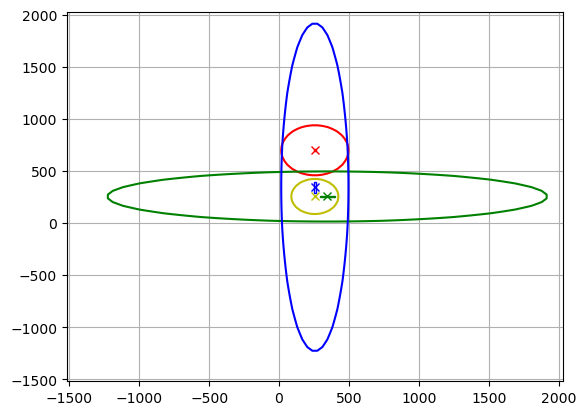

In [100]:
# Plot conic using equation A*x**2 + B*x*y + C*y**2 = 1
# where A, B, C are the conic parameters

# plot the boundary where the equation is satisfied


# Get gaussian indices sorted by depth (pos_screen[2])
indices = np.argsort([pos_cam[2] for conic, _, pos_cam, _ in conics_and_bbs])

def plot_conics_and_bbs(conics_and_bbs, camera):
    # convert to NDC
    x_cam, y_cam = np.linspace(-20, 20, 100), np.linspace(-20, 20, 100)
    X_cam, Y_cam = np.meshgrid(x_cam, y_cam)

    ax = plt.gca()
    colors = ['r', 'g', 'b', 'y', 'm', 'c']

    for i,(conic, bb, pos_cam, coordxy) in enumerate(conics_and_bbs):
        if conic is None:
            continue

        A, B, C = conic

        # offset by gaussian position and compute F
        x =  X_cam - pos_cam[0]
        y =  Y_cam - pos_cam[1]
        # 3-sigma ellipse
        F = A*x**2 + 2*B*x*y + C*y**2 - 1.0

        projection_matrix = camera.get_projection_matrix()

        XY_cam = np.vstack([x_cam, x_cam, np.ones_like(x_cam)*pos_cam[2], np.ones_like(x_cam)])
        XY_px = projection_matrix @ XY_cam
        XY_px = XY_px / XY_px[3]
        # scale by w and h and offset to convert to pixel coordinates
        XY_px[0] = XY_px[0] * camera.w / 2 + camera.w / 2
        XY_px[1] = -XY_px[1] * camera.h / 2 + camera.h / 2

        X_px_flat = XY_px[0]
        Y_px_flat = XY_px[1]
        X_px, Y_px = np.meshgrid(X_px_flat, Y_px_flat)

        pos_screen = camera.cam_to_pixel(pos_cam)

        F_val = 0.0
        plt.contour(X_px, Y_px, F, [F_val], colors=colors[i])

        # Put a cross at the gaussian position
        plt.plot(pos_screen[0], pos_screen[1], 'x', color=colors[i])

        # Plot a rectangle around the gaussian position based on bb
        # coords_ndc = camera.ndc_to_pixel(coordxy)
        coords_px = coordxy + pos_screen

        ul = coords_px[0]
        ur = coords_px[1]
        lr = coords_px[2]
        ll = coords_px[3]

        # ax.add_patch(plt.Rectangle((pos_screen[0] - bb_x/2, pos_screen[1] - bb_y/2), bb_x, bb_y, fill=False, color=colors[i]))
        ax.add_patch(plt.Rectangle((ul[0], ul[1]), ur[0] - ul[0], lr[1] - ur[1], fill=False, color=colors[i]))

fig = plt.figure()
ax = plt.gca()
plot_conics_and_bbs(conics_and_bbs, camera)
# plt.xlim([0, camera.w*10.0])
# plt.ylim([0, camera.h*10.0])
plt.grid(True)
plt.show()


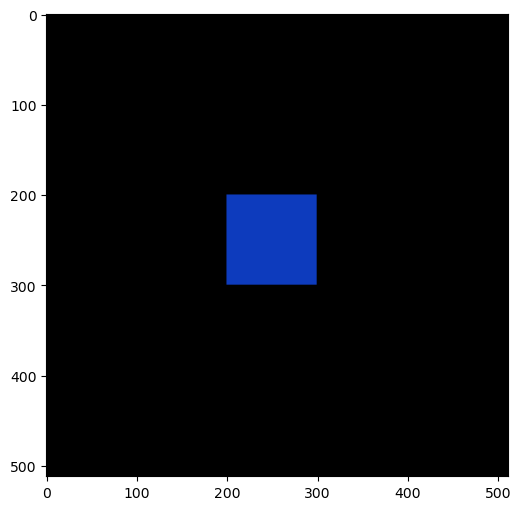

In [105]:
import importlib
import util

importlib.reload(util)

camera = util.Camera(512, 512)
# print(gaussian_objects[1].cov3D, gaussian_objects[1].pos)
conics_and_bbs = [gau.get_conic_and_bb(camera) for gau in gaussian_objects]


def plot_opacity(gaussian: Gaussian, camera: Camera, color: (int, int, int), w: int, h: int, bitmap: np.ndarray, alphas: np.ndarray):
    # Compute the opacity of a gaussian given the camera
    conic, bb, pos_cam, coordxy = gaussian.get_conic_and_bb(camera)

    A, B, C = conic
    # Iterate over and shade pixels in the bounding box
    projection_matrix = camera.get_projection_matrix()
    pos_ndc = projection_matrix @ pos_cam
    pos_ndc = pos_ndc / pos_ndc[3]
    pos_screen = np.array([(pos_ndc[0] + 1) * w/2, (1 - pos_ndc[1]) * h/2, pos_ndc[2]])

    minx = max(int(pos_screen[0] - bb[0]/2), 0)
    maxx = min(int(pos_screen[0] + bb[0]/2), w)

    y1 = int(pos_screen[1] - bb[1]/2)
    y2 = int(pos_screen[1] + bb[1]/2)
    miny, maxy = min(y1, y2), max(y1, y2)
    miny = max(miny, 0)
    maxy = min(maxy, h)

    for x in range(200, 300):
        for y in range(200, 300):
            if x < 0 or x >= w or y < 0 or y >= h:
                continue

            # Scale the pixel position to the camera coordinate system
            _x = (x*2) / w - 1
            _y = -(y*2) / h + 1

            # print(_x, _y, pos_cam)
            _x = _x - pos_cam[0]
            _y = _y - pos_cam[1]

            # Gaussian is typically calculated as f(x, y) = A * exp(-(a*x^2 + 2*b*x*y + c*y^2))
            power = -(A*_x**2 + C*_y**2)/2.0 - B * _x * _y

            if power > 0.0:
                continue

            opacity = gaussian.opacity * np.exp(power)
            opacity = min(0.99, opacity)
            if opacity < 1.0 / 255.0:
                continue

            # Set the pixel color to the given color and opacity
            # Do alpha blending using "over" method
            alpha = opacity*0.75
            old_alpha = alphas[y, x]
            new_alpha = alpha + old_alpha * (1.0 - alpha)

            alphas[y, x] = new_alpha
            bitmap[y, x, :] = (color[0:3]) * alpha + bitmap[y, x, :] * (1.0 - alpha)



# Initialize a bitmap with alpha channel of size w x h
(w, h) = (512, 512)
bitmap = np.zeros((w, h, 3), np.float32)
alphas = np.zeros((w, h))

plt.figure(figsize=(6,6))
colors = np.array([(1.0, 0, 0), (0, 1.0, 0), (0, 0, 1.0), (1.0, 1.0, 0), (1.0, 0, 1.0), (0, 1.0, 1.0)])
for idx in indices[0:4]:
    plot_opacity(gaussian_objects[idx], camera, colors[idx], w, h, bitmap, alphas)

# Plot the bitmap
plt.imshow(bitmap, alpha=alphas, interpolation='bilinear', vmin=0, vmax=1.0)

plt.show()
